In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.layers import MaxPooling2D,GlobalAveragePooling2D,BatchNormalization,Activation
import tensorflow_addons as tfa


In [28]:
from kaggle_secrets import UserSecretsClient
import wandb
from wandb.keras import WandbCallback
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb-api-key") 
wandb.login(key=wandb_api)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [29]:
train_directory = '../input/plant-pathology-2021-fgvc8/train_images'
test_directory =  '../input/plant-pathology-2021-fgvc8/test_images'

In [30]:
train_data = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')

In [31]:
train_data.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [32]:
train_data['labels'].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


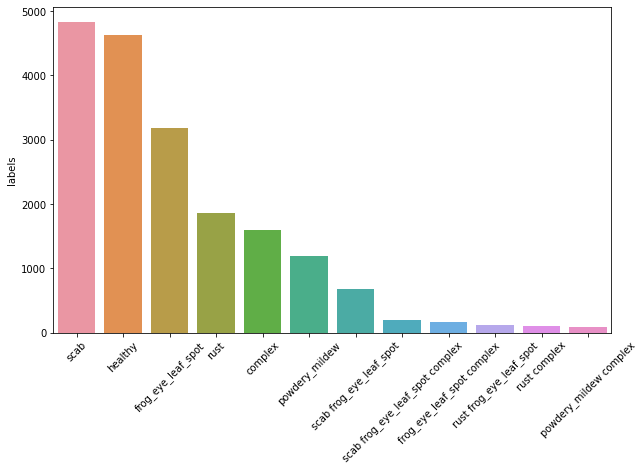

In [33]:
plt.figure(figsize=(10,6))

labels = sns.barplot(train_data.labels.value_counts().index,train_data.labels.value_counts())

for item in labels.get_xticklabels():
    item.set_rotation(45)

In [34]:
train_data['labels'] = train_data['labels'].apply(lambda s: s.split(' '))

In [35]:
list_of_labels = list(train_data['labels'])

mlb = MultiLabelBinarizer()

label_dataframe = pd.DataFrame(mlb.fit_transform(list_of_labels), columns=mlb.classes_, index=train_data.index)

print(label_dataframe.columns)

Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')


<AxesSubplot:>

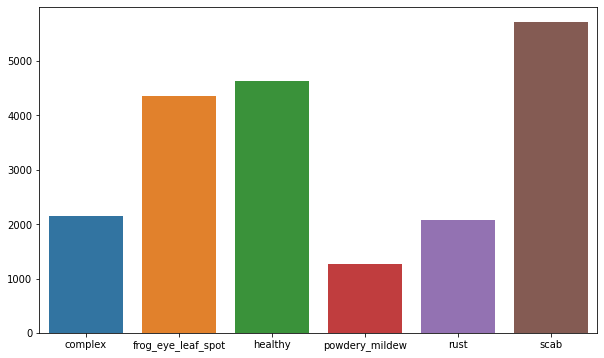

In [36]:
labels = list(label_dataframe.sum().keys())

label_counts = label_dataframe.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(10,6))

sns.barplot(x= labels, y= label_counts, ax=ax)

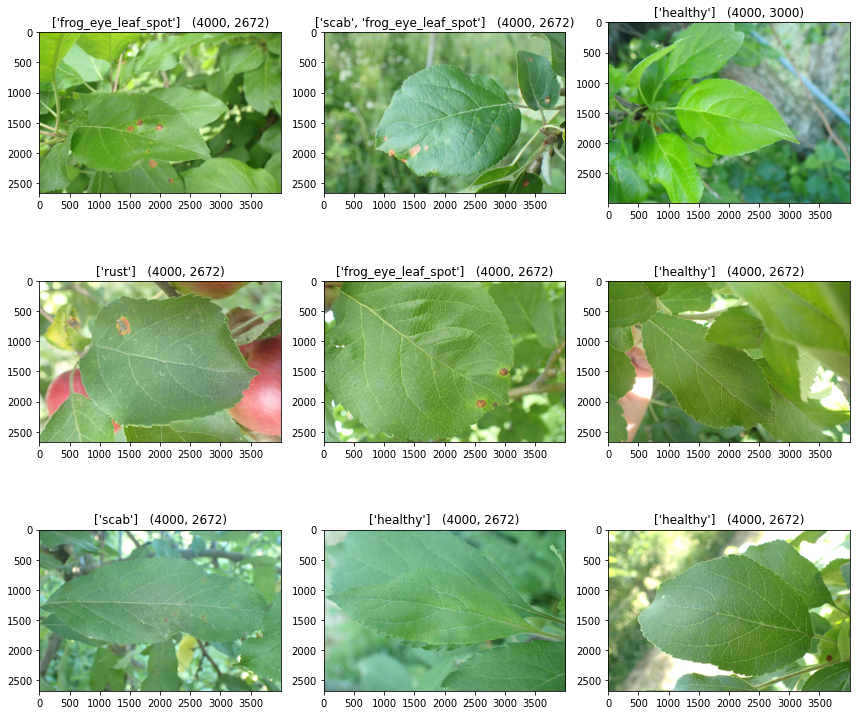

In [37]:
fig1 = plt.figure(figsize=(12,12))

for i in range(1, 10):
    random_number =  random.randrange(1, 18000)
    sample_image = os.path.join('../input/plant-pathology-2021-fgvc8/train_images/', train_data['image'][random_number])
    
    img = PIL.Image.open(sample_image)
    
    ax = fig1.add_subplot(3,3,i)
    ax.imshow(img)
    
    title = f"{train_data['labels'][random_number]}   {img.size}"
    plt.title(title)
    
    fig1.tight_layout()

In [38]:
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    brightness_range = None,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split= 0.15
)

In [39]:
X_COL = 'image'
Y_COL = 'labels'
COLOR_MODE = 'rgb'
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
TARGET_SIZE = (IMAGE_HEIGHT,IMAGE_WIDTH)
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
CLASS_MODE = 'categorical'
BSIZE = 16

In [40]:
training_set = datagen.flow_from_dataframe(
    train_data,
    directory = '../input/resized-plant2021/img_sz_512',# We are using the resized images otherwise it will take a lot of time to train 
    x_col = X_COL,
    y_col = Y_COL,
    subset = "training",
    color_mode = COLOR_MODE,
    target_size = TARGET_SIZE,
    class_mode = CLASS_MODE,
    batch_size = BSIZE,
    shuffle=False,
    seed=40
)

Found 15838 validated image filenames belonging to 6 classes.


In [41]:
validation_set = datagen.flow_from_dataframe(
    train_data,
    directory = '../input/resized-plant2021/img_sz_512',
    x_col = X_COL,
    y_col = Y_COL,
    subset="validation",
    color_mode = COLOR_MODE,
    target_size = TARGET_SIZE,
    class_mode = CLASS_MODE,
    batch_size = BSIZE,
    shuffle=False,
    seed=40
)

Found 2794 validated image filenames belonging to 6 classes.


In [42]:
base_model = tf.keras.applications.EfficientNetB7(input_shape=INPUT_SHAPE, include_top=False,weights= "imagenet")

In [43]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
#fully connected layer
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)

# finally, the softmax for the classifier 
predictions = tf.keras.layers.Dense(6, activation='sigmoid')(x)

In [44]:
model = tf.keras.Model(inputs=base_model.input ,outputs = predictions)

threshold_x = 0.25

optimizer = tf.keras.optimizers.Adam()

f1 = tfa.metrics.F1Score(num_classes=6, average='macro',threshold = threshold_x)

In [45]:
checkpoint_path = "training/efficientnet-cp-{epoch:04d}.ckpt"

In [46]:
#callback functions

learningrate_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                          factor=0.05, 
                                                          patience=5, 
                                                          verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor=f1, 
                                                 patience=3, 
                                                 mode='max', 
                                                 restore_best_weights=True)


checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                        verbose=1, 
                                                        save_weights_only=True,
                                                        save_freq='epoch')

In [47]:
CONFIG = dict (
    num_labels = 6,
    train_val_split = 0.15,
    img_width = IMAGE_WIDTH,
    img_height = IMAGE_HEIGHT,
    batch_size = BSIZE,
    epochs = 15,
    learning_rate = 0.001,
    architecture = "CNN",
    infra = "Kaggle",
    model_name = "EfficientNet"
)

CONFIG['model_name'] = 'EfficientNet'

print('Training configuration: ', CONFIG)

# Initialize W&B run
run = wandb.init(project='plant-pathology', 
                 config=CONFIG,
                 group='EfficientNet', 
                 job_type='train')


callbacks_list = [early_stopping, learningrate_scheduler, checkpoint_callback, WandbCallback()]

Training configuration:  {'num_labels': 6, 'train_val_split': 0.15, 'img_width': 224, 'img_height': 224, 'batch_size': 16, 'epochs': 15, 'learning_rate': 0.001, 'architecture': 'CNN', 'infra': 'Kaggle', 'model_name': 'EfficientNet'}


wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [48]:
wandb.config.type = 'baseline'
wandb.config.kaggle_competition = 'Plant Pathology 2021 - FGVC8'

In [49]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer, metrics=[f1])

In [50]:
history = model.fit(training_set, validation_data= validation_set, callbacks=callbacks_list, epochs = 15) 
run.finish()

Epoch 1/15
990/990 [==============================] - 706s 685ms/step - loss: 0.3000 - f1_score: 0.5744 - val_loss: 0.1278 - val_f1_score: 0.8398

Epoch 00001: saving model to training/efficientnet-cp-0001.ckpt
Epoch 2/15
990/990 [==============================] - 656s 663ms/step - loss: 0.1507 - f1_score: 0.8058 - val_loss: 0.1435 - val_f1_score: 0.8226

Epoch 00002: saving model to training/efficientnet-cp-0002.ckpt
Epoch 3/15
990/990 [==============================] - 656s 663ms/step - loss: 0.1274 - f1_score: 0.8306 - val_loss: 0.1372 - val_f1_score: 0.8417

Epoch 00003: saving model to training/efficientnet-cp-0003.ckpt
Epoch 4/15
990/990 [==============================] - 656s 662ms/step - loss: 0.1172 - f1_score: 0.8471 - val_loss: 0.1115 - val_f1_score: 0.8393

Epoch 00004: saving model to training/efficientnet-cp-0004.ckpt
Epoch 5/15
990/990 [==============================] - 656s 662ms/step - loss: 0.1104 - f1_score: 0.8519 - val_loss: 0.1058 - val_f1_score: 0.8637

Epoch 000

epoch,14
loss,0.07898
f1_score,0.89345
val_loss,0.09047
val_f1_score,0.88741
lr,0.001
_runtime,9971
_timestamp,1630078044
_step,14
best_val_loss,0.08655
best_epoch,12


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
f1_score,▁▅▆▆▇▇▇▇▇▇█████
val_loss,▆█▇▄▃▄▆▂▂▄▂▂▁▂▁
val_f1_score,▃▁▃▃▅▄▄▇▆▅▇██▇▇
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▃▄▄▄▅▆▆▆▇██
_timestamp,▁▂▂▂▃▄▄▄▅▆▆▆▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


In [51]:
model.save('pp_research02(EfficientNet).h5')